### Load libraries 




In [1]:
import pandas as pd 
import pickle
from IPython import display
import datetime
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os 
import sys

In [2]:
pd.__version__

'1.1.4'

In [3]:
#!pwd
print(os.getcwd())

D:\Documents\Education\University\4th Year\ELEC6200 - Group Design Project\gdp-wild-dogs


### Checking OS system 
- slight difference in file path for different OS systems:
    - linux: '/home/user/Data'
    - windows: 'C:\\user\\Data'

In [4]:
os_system = sys.platform
if os_system.startswith('win'):
    os_system = 'windows'
print('OS System: ', os_system)

OS System:  windows


### List Directory Tree

In [5]:
def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        for f in files:
            print('{}{}'.format(subindent, f))

In [6]:
list_files(os.path.join(os.getcwd(), 'Data'))

Data/
    2020-11-05/
        201105_807d3a2a0fe8_xyz.pkl
        cut.pkl
        cutoff.txt
        dataFeatured.pkl
        labelled.pkl
        labels.csv
        raw.pkl
    2020-11-16/
        201116_807d3a2a0fe8_xyz.pkl
        cut.pkl
        cutoff.txt
        dataFeatured.pkl
        labelled.pkl
        labels.csv
        raw.pkl
    2020-11-23/
        201123_807d3a2a0fe8_xyz.pkl
        cut.pkl
        cutoff.txt
        dataFeatured.pkl
        labelled.pkl
        labels.csv
        raw.pkl
    2020-11-26/
        201126_807d3a2a0fe8_xyz.pkl
        cut.pkl
        cutoff.txt
        dataFeatured.pkl
        labelled.pkl
        labels.csv
        raw.pkl
    2020-11-27/
        201127_807d3a2a0fe8_xyz.pkl
        cut.pkl
        cutoff.txt
        dataFeatured.pkl
        labelled.pkl
        labels.csv
        raw.pkl
    2020-11-28/
        201128_807d3a2a0fe8_xyz.pkl
        raw.pkl
    2020-12-03/
        201203_807d3a2a0fe8.pkl
        201203_807d3a2a0fe8_xyz.pkl
  

 ### Functions to Trim, Load, and Label data

In [7]:
os_system = sys.platform
if os_system.startswith('win'):
    os_system = 'windows'
print('OS System: ', os_system)

if os_system == 'linux':
    filepath = './Data'
    pathstyle = '/'
elif os_system == 'windows':
    filepath = 'Data'
    pathstyle = '\\'

def trimData(folderPath):
    for subdir, dirs, files in os.walk(folderPath):
        if subdir != "Data":
            cutoffPresent = 0
            for filename in os.listdir(subdir):
                if filename == "cutoff.txt":
                    cutoffPresent = 1
                    f = open('./'+subdir+'/cutoff.txt', "r")
                    start = f.readline()
                    start = datetime.time(int(start.split(",")[0]), int(start.split(",")[1]), int(start.split(",")[2]))
                    end = f.readline()
                    end = datetime.time(int(end.split(",")[0]), int(end.split(",")[1]), int(end.split(",")[2]))
            for filename in os.listdir(subdir):
                if cutoffPresent == 1:
                    if filename == "raw.pkl":
                        df = pd.read_pickle(subdir+pathstyle+ filename)
                        df.reset_index(inplace=True)
                        df = df.drop(['mag_x', 'mag_y', 'mag_z', 'pressure'], axis=1)
                        df = df.loc[(df['dt'].dt.time > start) & (df['dt'].dt.time < end)]
                        df.to_pickle("./"+subdir+"/cut.pkl")
                        print("cut saved in: ", subdir)
                        cutoffPresent = 0
    return 0

def loadData(folderPath):
    for filename in os.listdir(folderPath):
        if filename == "cut.pkl":
            data = pd.read_pickle(folderPath+pathstyle+ filename)
            data.reset_index(inplace=True)
            return data

def loadLabels(folderPath):
    for filename in os.listdir(folderPath):
        if filename == "labels.csv":
            labels = pd.read_csv(folderPath+pathstyle+filename)
            labels.reset_index(inplace=True)
            return labels

def labelData(data, labels):
    if('activity' in data.columns):
                    data.drop('activity', 1, inplace=True)

    labelsList = []
    intervalIndex = 0
    intervalBegin = pd.to_datetime(labels['start_time'][intervalIndex], utc=True)
    intervalEnd = pd.to_datetime(labels['end_time'][intervalIndex], utc=True)
    for i in range(0, len(data)):
        time = pd.to_datetime(data['dt'][i])
        while(time > intervalEnd):
            if(intervalIndex + 1 >= len(labels)):
                break
            intervalIndex += 1
            intervalBegin = pd.to_datetime(labels['start_time'][intervalIndex], utc=True)
            intervalEnd = pd.to_datetime(labels['end_time'][intervalIndex], utc=True)
        if(time > intervalEnd or time < intervalBegin):
            labelsList.append("None")
        else:
            labelsList.append(labels["activity"][intervalIndex])
    data["activity"] = labelsList

def loadAndLabel():
        
    labelledDfList = []

    for subdir, dirs, files in os.walk(filepath):
        if subdir != "Data":
            data = loadData(subdir)
            labels = loadLabels(subdir)
            if (data is not None) & (labels is not None):
                print("Labelled Data from {}".format((str(pd.to_datetime(data['dt'][0], utc=True))[0:10])))
                labelData(data, labels)
                labelledDfList.append(data)
                
    return labelledDfList

OS System:  windows


In [8]:
dfList = loadAndLabel()

Labelled Data from 2020-11-05
Labelled Data from 2020-11-16
Labelled Data from 2020-11-23
Labelled Data from 2020-11-26
Labelled Data from 2020-11-27


# Unvsupervised investigation

In [33]:
def sessionsToArrays(sessionList):
    sessionArrays = []
    
    sessionList.append(pd.concat(sessionList,ignore_index=True, sort=False))
    
    for session in sessionList:
        session.drop(session.loc[session['activity']=="None"].index, inplace=True)
        session.drop(session.loc[session['activity']=="playing"].index, inplace=True)
        if 'level_0' in session.columns:
            session = session.drop(["level_0"], axis=1)
        session.reset_index(inplace=True)
        sessionArrays.append(session[['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']].values)
    
    return sessionArrays

def fitKMeans(sessionArray):
    kmeans = KMeans(n_clusters=10)
    kmeans.fit(sessionArray)
    return kmeans

def evaluateLabels(session, labels):
    activities = session["activity"].unique()
    grid = []
    session['labels'] = labels
    for activity in activities:
        activityData = session[session['activity'] == activity]
        perc = []
        
        print(activity)
        if len(activityData) != 0:
            for x in range(0,10):
                perc.append((len(activityData[activityData['labels'] == x])/len(activityData))*100)
            max_value = max(perc)
            max_index = perc.index(max_value)
            print(max_value, "% in label ", max_index)
            grid.append(perc)
        else:
            print("None of activity in dataset")
            activities.remove(activity)
    grid = pd.DataFrame(grid).transpose()
    grid.columns = activities
    fig = plt.figure()
    ax = sns.heatmap(grid.transpose())
    ax.set_xlabel("Clusters")
    ax.set_ylabel("Activities")

In [10]:
sessionArrays = sessionsToArrays(dfList)
print(len(sessionArrays))
for x in sessionArrays:
    print(len(x))

6
16770
75386
50117
86327
26102
254702


In [11]:
kmeans1 = fitKMeans(sessionArrays[0])
kmeans2 = fitKMeans(sessionArrays[1])
kmeans3 = fitKMeans(sessionArrays[2])
kmeansComb = fitKMeans(sessionArrays[-1])

Session 1
jumping
24.91767288693743 % in label  9
galloping
20.830078125 % in label  9
sitting
90.11857707509881 % in label  9
barking
71.96261682242991 % in label  9
trotting
31.062271062271062 % in label  9
walking
40.32934131736527 % in label  9
laying
96.57039711191335 % in label  9


Session 2
sniffing
58.77917414721724 % in label  5
walking
37.67988916848088 % in label  5
standing
86.55304452286208 % in label  5
trotting
19.593001613103365 % in label  0
galloping
16.7572633552015 % in label  4
laying
94.23185143500281 % in label  5
eating
68.96551724137932 % in label  5
sitting
91.33986928104575 % in label  5


Session 3
walking
26.40919854502844 % in label  0
sniffing
61.17673784643344 % in label  0
standing
76.98170731707317 % in label  0
trotting
17.99812030075188 % in label  6


Sessions Combined:
jumping
19.957761351636748 % in label  8
galloping
12.689881685514873 % in label  7
sitting
90.39871677360219 % in label  1
barking
60.18518518518518 % in label  1
trotting
20.92176

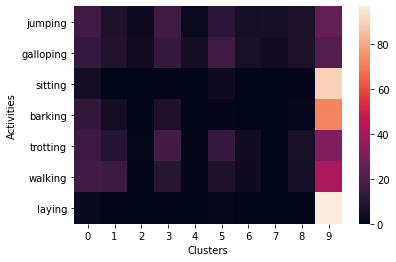

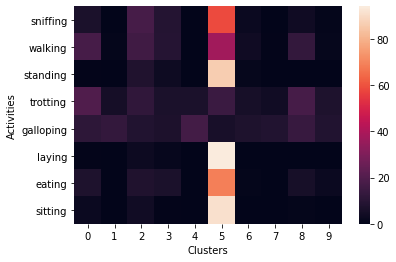

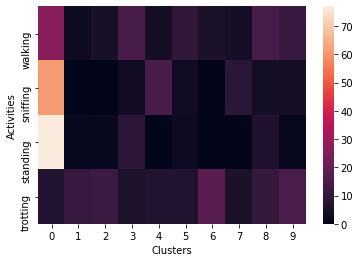

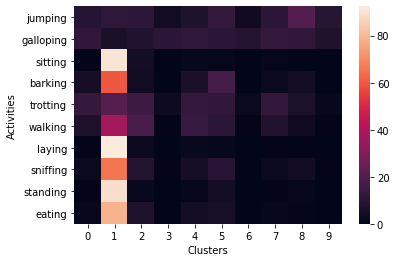

In [34]:
combSessions = pd.concat(dfList[0:-1], sort=False)
combSessions = combSessions.drop(['level_0'], axis=1)
combSessions.reset_index(inplace=True, drop=True)

print("Session 1")
evaluateLabels(dfList[0], kmeans1.labels_)
print("\n\nSession 2")
evaluateLabels(dfList[1], kmeans2.labels_)
print("\n\nSession 3")
evaluateLabels(dfList[2], kmeans3.labels_)

print("\n\nSessions Combined:")
evaluateLabels(combSessions, kmeansComb.labels_)

## Add Some features (mean/var)

In [35]:
query_variables = ["acc_x", "acc_y", "acc_z", "gyro_x", "gyro_y", "gyro_z"]
composite_variables = []
windowSize = 10 #Maximum Size of window on either side of point
dfIndex = 0;
show_progress=False
dfList_meanvar = dfList[0:-1]
for df in dfList_meanvar:
    print("Starting DF " + str(dfIndex))
    values = {}
    for variable in query_variables:
            values[variable + "_MEAN"] = []
            values[variable + "_VAR"] = []
    for i in range(0, len(df.index)):
        minIndex = 0
        maxIndex = len(df.index)
        if(i >= windowSize):
            minIndex = i - windowSize
        if(i <= len(df.index)-1-windowSize):
            maxIndex = i+windowSize
        slice = df.iloc[minIndex:maxIndex+1]
        for variable in query_variables:
            values[variable + "_MEAN"].append(slice[variable].mean())
            values[variable + "_VAR"].append(slice[variable].var())
        if(show_progress):
            display.clear_output()
            print("Processing Dataframe: " + str(dfIndex))
            print("Percentage Finished: " + str(float(i)*100/len(df.index)) + "%")
    for variable in query_variables:
            df[variable + "_MEAN"] = values[variable + "_MEAN"]
            df[variable + "_VAR"] = values[variable + "_VAR"]
            if(not (variable + "_MEAN") in composite_variables):
                composite_variables.append((variable + "_MEAN"))
            if(not (variable + "_VAR") in composite_variables):
                composite_variables.append((variable + "_VAR"))
    dfIndex += 1

Starting DF 0
Starting DF 1
Starting DF 2
Starting DF 3
Starting DF 4


In [36]:
sessionArrays_meanvar = sessionsToArrays(dfList_meanvar)
print(len(sessionArrays_meanvar))
for x in sessionArrays_meanvar:
    print(len(x))

6
16770
75386
50117
86327
26102
254702


In [37]:
kmeans1_meanvar = fitKMeans(sessionArrays_meanvar[0])
kmeans2_meanvar = fitKMeans(sessionArrays_meanvar[1])
kmeans3_meanvar = fitKMeans(sessionArrays_meanvar[2])
kmeansComb_meanvar = fitKMeans(sessionArrays_meanvar[-1])

Session 1
jumping
24.91767288693743 % in label  4
galloping
20.869140625 % in label  4
sitting
90.11857707509881 % in label  4
barking
71.96261682242991 % in label  4
trotting
31.135531135531135 % in label  4
walking
40.29940119760479 % in label  4
laying
96.57039711191335 % in label  4


Session 2
sniffing
58.86295631358468 % in label  0
walking
37.77884588198705 % in label  0
standing
86.47796381109693 % in label  0
trotting
19.543367663481824 % in label  9
galloping
16.663542642924085 % in label  3
laying
94.20371412492966 % in label  0
eating
68.83780332056195 % in label  0
sitting
91.17647058823529 % in label  0


Session 3
walking
26.316431901960307 % in label  4
sniffing
61.085870059064064 % in label  4
standing
76.90548780487805 % in label  4
trotting
18.092105263157894 % in label  3


Sessions Combined:
jumping
19.640971488912353 % in label  3
galloping
12.660023140372486 % in label  0
sitting
90.39871677360219 % in label  1
barking
60.18518518518518 % in label  1
trotting
20.

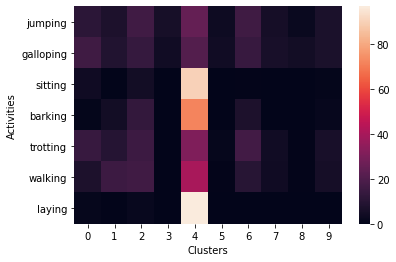

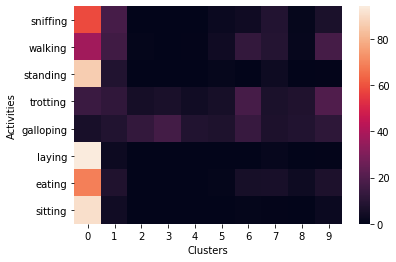

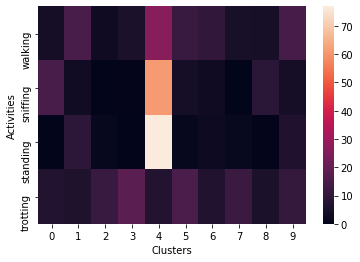

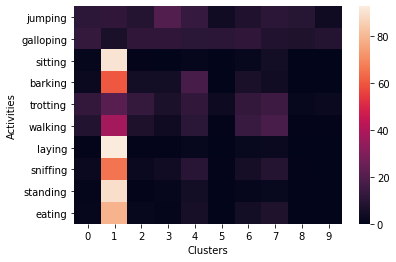

In [38]:
combSessions_meanvar = pd.concat(dfList_meanvar[0:-1], sort=False)
#combSessions_meanvar = combSessions.drop(['level_0'], axis=1)
combSessions_meanvar.reset_index(inplace=True, drop=True)

print("Session 1")
evaluateLabels(dfList_meanvar[0], kmeans1_meanvar.labels_)
print("\n\nSession 2")
evaluateLabels(dfList_meanvar[1], kmeans2_meanvar.labels_)
print("\n\nSession 3")
evaluateLabels(dfList_meanvar[2], kmeans3_meanvar.labels_)

print("\n\nSessions Combined:")
evaluateLabels(combSessions_meanvar, kmeansComb_meanvar.labels_)

In [39]:
def add_reciprocal_column(df, column1, column2, dfIndex, log=False, verbose=False):
    count = 0
    if(column1 in df.columns and column2 in df.columns):
        print("Forming reciprocal of " + column1 + "/" + column2)
        reciprocal_vals = []
        if((column1 + "/" + column2) in df.columns):
            df.drop(column1 + "/" + column2, 1, inplace=True)
        
        new_df = df
        for i in range(len(df)):
            x = df[column1][i]
            y = df[column2][i]
            if(x == 0):
                x = 0.00001
            if(y == 0):
                y = 0.00001
            
            result = x/y
            if(np.isnan(result) or np.isinf(result)):
                count += 1
                result = 0.00001
            if(log):
                result = np.log10(np.abs(result))
            reciprocal_vals.append(result)
            
            if(verbose):
                display.clear_output()
                print("Forming reciprocal of " + column1 + "/" + column2 + " for Dataframe " + str(dfIndex))
                print("Percentage Finished: " + str(float(i)*100/len(df)) + "%")
                print("NaN or Inf results: " + str(count))
        new_df[column1 + "/" + column2] = reciprocal_vals
        
        return new_df
    else:
        print("Columns not present in Dataframe. Cannot form Reciprocal!")

In [40]:
dfList_recip = dfList_meanvar[0:-1]
for i in range(0,len(dfList_recip)):
    dfList_recip[i] = add_reciprocal_column(dfList_recip[i], "acc_x", "acc_y", i, log=True)
for i in range(0,len(dfList_recip)):
    dfList_recip[i] = add_reciprocal_column(dfList_recip[i], "acc_x", "acc_z", i, log=True)
for i in range(0,len(dfList_recip)):
    dfList_recip[i] = add_reciprocal_column(dfList_recip[i], "acc_y", "acc_z", i, log=True)

Forming reciprocal of acc_x/acc_y
Forming reciprocal of acc_x/acc_y
Forming reciprocal of acc_x/acc_y
Forming reciprocal of acc_x/acc_y
Forming reciprocal of acc_x/acc_y
Forming reciprocal of acc_x/acc_z
Forming reciprocal of acc_x/acc_z
Forming reciprocal of acc_x/acc_z
Forming reciprocal of acc_x/acc_z
Forming reciprocal of acc_x/acc_z
Forming reciprocal of acc_y/acc_z
Forming reciprocal of acc_y/acc_z
Forming reciprocal of acc_y/acc_z
Forming reciprocal of acc_y/acc_z
Forming reciprocal of acc_y/acc_z


In [41]:
sessionArrays_recip = sessionsToArrays(dfList_recip)
print(len(sessionArrays_recip))
for x in sessionArrays_recip:
    print(len(x))

6
16770
75386
50117
86327
26102
254702


In [42]:
kmeans1_recip = fitKMeans(sessionArrays_recip[0])
kmeans2_recip = fitKMeans(sessionArrays_recip[1])
kmeans3_recip = fitKMeans(sessionArrays_recip[2])
kmeansComb_recip = fitKMeans(sessionArrays_recip[-1])

Session 1
jumping
25.13721185510428 % in label  1
galloping
20.732421875 % in label  1
sitting
90.11857707509881 % in label  1
barking
71.02803738317756 % in label  1
trotting
31.135531135531135 % in label  1
walking
40.1497005988024 % in label  1
laying
96.38989169675091 % in label  1


Session 2
sniffing
58.95870736086176 % in label  5
walking
37.83539257541915 % in label  5
standing
86.51550416697951 % in label  5
trotting
19.568184638292593 % in label  1
galloping
16.719775070290535 % in label  7
laying
94.28812605514912 % in label  5
eating
68.83780332056195 % in label  5
sitting
91.33986928104575 % in label  5


Session 3
walking
26.38722749798599 % in label  4
sniffing
61.1085870059064 % in label  4
standing
76.9435975609756 % in label  4
trotting
17.99812030075188 % in label  1


Sessions Combined:
jumping
19.746568109820487 % in label  9
galloping
12.708543276228864 % in label  7
sitting
90.35288725939506 % in label  6
barking
60.18518518518518 % in label  6
trotting
20.926966

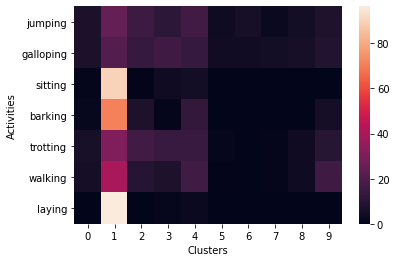

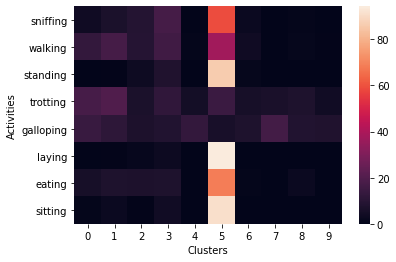

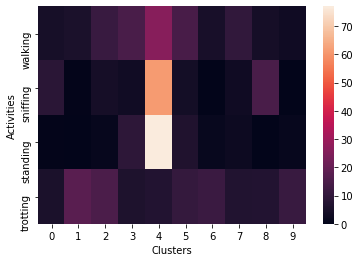

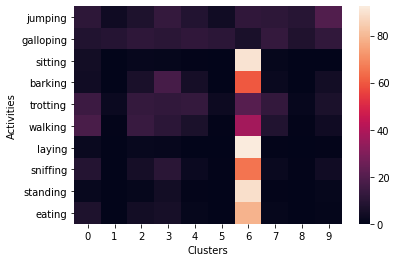

In [43]:
print("Session 1")
evaluateLabels(dfList_recip[0], kmeans1_recip.labels_)
print("\n\nSession 2")
evaluateLabels(dfList_recip[1], kmeans2_recip.labels_)
print("\n\nSession 3")
evaluateLabels(dfList_recip[2], kmeans3_recip.labels_)

print("\n\nSessions Combined:")
evaluateLabels(dfList_recip[-1], kmeansComb_recip.labels_)

In [44]:
from skimage import util

# M = Window Size, Rate in Hz
def calculate_fourier(column, df, rate, label, use_label=False, M = 64, freq_limit=-1, show=False):
    if(column in df.columns):
        data = np.array(df[column])
        if(use_label):
            data = np.array(df.loc[df['activity'] == label][column])
        N = data.shape[0]
        if(N <= M):
            if(use_label):
                print("Insufficient Data for activity: " + label)
            else:
                print("Insufficient Complete Data")
            return []
        L = N / rate
        slices = util.view_as_windows(data, window_shape=(M,), step=1)
        slices = slices * np.hanning(M + 1)[:-1]
        slices = slices.T
        spectrum = np.fft.fft(slices, axis=0)[:M // 2 + 1:-1]
        spectrum = np.abs(spectrum)
        

        S = np.abs(spectrum)
        #S = 20 * np.log10(S / np.max(S))
        S = S / np.max(S)

        if(show):
            f, ax = plt.subplots(figsize=(20, 10))
            if(freq_limit != -1):
                ax.imshow(S[0:freq_limit], origin='lower', cmap='viridis', extent=(0, L, 0, freq_limit))
            else:
                ax.imshow(S, origin='lower', cmap='viridis', extent=(0, L, 0, np.max(np.fft.fftfreq(M, d=1/rate))))
            ax.axis('tight')
            y_label = 'Frequency [Hz] of value: '
            y_label = y_label + column
            ax.set_ylabel(y_label)
            ax.set_xlabel(label + ' Time [s]');
        #S has first index referencing frequency in Hz, second index is window index
        #print(L)
        return S

def add_fourier_variables(variable_frequencies, labelledDFList, window_size):
    fourier_variables = []
    for df in labelledDFList:
        for variable in variable_frequencies:
            frequency_indices = variable_frequencies[variable]
            S = calculate_fourier(variable, df, 50, '', use_label=False, M=window_size, show=False)
            for frequency_index in frequency_indices:
                new_column = []
                new_column.extend(np.zeros(window_size-1))
                new_column.extend(S[frequency_index])
                print(variable + " at frequency index: " + str(frequency_index))
                new_var_name = variable + "_freq_" + str(frequency_index)
                if(new_var_name in df.columns):
                    df.drop(new_var_name, 1, inplace=True)
                df[new_var_name] = new_column
                if(not new_var_name in fourier_variables):
                    fourier_variables.append(new_var_name)
    return fourier_variables

labels_of_interest = ['jumping', 'galloping', 'sitting', 'barking', 'trotting', 'walking', 'laying', 'sniffing', 'playing', 'standing', 'eating', 'sleeping', 'hunting']
#labels_of_interest = ['sitting', 'laying', 'standing', 'eating', 'sleeping']
value = "acc_y/acc_z"
do_log=False
freq_limit = 15
useful_frequencies = {'acc_x': [0, 2, 3, 4, 5, 7], 'acc_y': [0, 4, 5], 'acc_z': [0, 2, 3, 4, 5], 'gyro_x': [5], 'gyro_y': [3, 4], 'acc_x/acc_y': [0, 2, 3, 4], 'acc_x/acc_z': [5], 'acc_y/acc_z': [0, 2, 3]}

In [45]:
dfList_fourier = dfList[0:-1]
fourier_vars = add_fourier_variables(useful_frequencies, dfList_fourier, 80)

acc_x at frequency index: 0
acc_x at frequency index: 2
acc_x at frequency index: 3
acc_x at frequency index: 4
acc_x at frequency index: 5
acc_x at frequency index: 7
acc_y at frequency index: 0
acc_y at frequency index: 4
acc_y at frequency index: 5
acc_z at frequency index: 0
acc_z at frequency index: 2
acc_z at frequency index: 3
acc_z at frequency index: 4
acc_z at frequency index: 5
gyro_x at frequency index: 5
gyro_y at frequency index: 3
gyro_y at frequency index: 4
acc_x/acc_y at frequency index: 0
acc_x/acc_y at frequency index: 2
acc_x/acc_y at frequency index: 3
acc_x/acc_y at frequency index: 4
acc_x/acc_z at frequency index: 5
acc_y/acc_z at frequency index: 0
acc_y/acc_z at frequency index: 2
acc_y/acc_z at frequency index: 3
acc_x at frequency index: 0
acc_x at frequency index: 2
acc_x at frequency index: 3
acc_x at frequency index: 4
acc_x at frequency index: 5
acc_x at frequency index: 7
acc_y at frequency index: 0
acc_y at frequency index: 4
acc_y at frequency index:

In [46]:
sessionArrays_fourier = sessionsToArrays(dfList_fourier)
print(len(sessionArrays_fourier))
for x in sessionArrays_fourier:
    print(len(x))

6
16770
75386
50117
86327
26102
254702


In [47]:
kmeans1_fourier = fitKMeans(sessionArrays_fourier[0])
kmeans2_fourier = fitKMeans(sessionArrays_fourier[1])
kmeans3_fourier = fitKMeans(sessionArrays_fourier[2])
kmeansComb_fourier = fitKMeans(sessionArrays_fourier[-1])

Session 1
jumping
25.027442371020857 % in label  5
galloping
20.888671875 % in label  5
sitting
90.11857707509881 % in label  5
barking
71.96261682242991 % in label  5
trotting
31.135531135531135 % in label  5
walking
40.29940119760479 % in label  5
laying
96.57039711191335 % in label  5


Session 2
sniffing
58.82704967085578 % in label  2
walking
37.7477452005994 % in label  2
standing
86.48547188227344 % in label  2
trotting
19.630227075319517 % in label  5
galloping
16.62605435801312 % in label  9
laying
94.23185143500281 % in label  2
eating
68.71008939974456 % in label  2
sitting
91.17647058823529 % in label  2


Session 3
walking
26.794912481995947 % in label  1
sniffing
61.13130395274875 % in label  1
standing
77.85823170731707 % in label  1
trotting
17.716165413533837 % in label  7


Sessions Combined:
jumping
20.16895459345301 % in label  5
galloping
12.678684731086479 % in label  4
sitting
90.39871677360219 % in label  7
barking
60.18518518518518 % in label  7
trotting
21.036

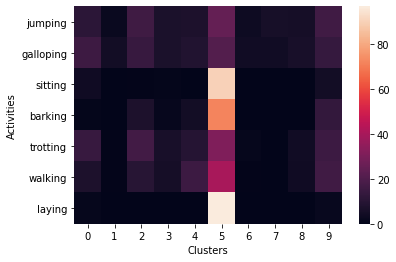

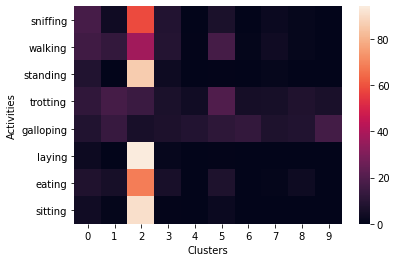

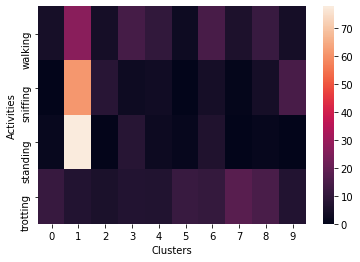

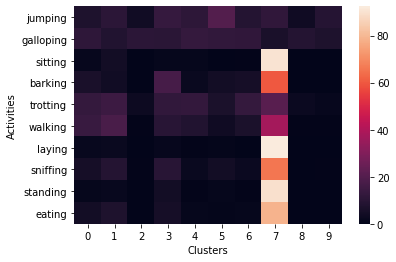

In [48]:
print("Session 1")
evaluateLabels(dfList_fourier[0], kmeans1_fourier.labels_)
print("\n\nSession 2")
evaluateLabels(dfList_fourier[1], kmeans2_fourier.labels_)
print("\n\nSession 3")
evaluateLabels(dfList_fourier[2], kmeans3_fourier.labels_)

print("\n\nSessions Combined:")
evaluateLabels(dfList_fourier[-1], kmeansComb_fourier.labels_)